# Blast wave simulation in 3D with the 5th order finite difference MHD solver

## Imports

In [1]:
# ==== GPU selection ====
from autocvd import autocvd
autocvd(num_gpus=1)
# =======================

# numerics
import jax
import jax.numpy as jnp

# jax.config.update("jax_enable_x64", True)

from jf1uids._finite_difference._interface_fluxes._weno import (
    _weno_flux_x,
    _weno_flux_y,
    _weno_flux_z,
)

from jf1uids._finite_difference._maths._differencing import finite_difference_int6

from jf1uids._finite_difference._magnetic_update._constrained_transport import (
    constrained_transport_rhs,
    initialize_interface_fields,
)

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.initial_condition_generation.construct_primitive_state import (
    construct_primitive_state,
)
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import (
    DOUBLE_MINMOD,
    FINITE_DIFFERENCE,
    HLLC_LM,
    LAX_FRIEDRICHS,
    VAN_ALBADA_PP,
    finalize_config,
)
import numpy as np
from matplotlib.colors import LogNorm

from jf1uids._finite_volume._magnetic_update._magnetic_field_update import (
    magnetic_update,
)

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


from jf1uids._finite_difference._fluid_equations._equations import (
    conserved_state_from_primitive_mhd,
)
# from jf1uids._finite_difference._magnetic_update._constrained_transport import initialize_face_centered_b

# jf1uids constants
from jf1uids.option_classes.simulation_config import (
    BACKWARDS,
    FORWARDS,
    HLL,
    HLLC,
    MINMOD,
    OSHER,
    PERIODIC_BOUNDARY,
    BoundarySettings,
    BoundarySettings1D,
)


## Simulation setup

In [ ]:
num_cells = 128
B0 = 10
box_size = 1.0

# setup simulation config
config = SimulationConfig(
    solver_mode=FINITE_DIFFERENCE,
    memory_analysis=True,
    runtime_debugging=False,
    progress_bar=True,
    mhd=True,
    dimensionality=3,
    box_size=box_size,
    num_cells=num_cells,
    boundary_settings=BoundarySettings(
        BoundarySettings1D(
            left_boundary=PERIODIC_BOUNDARY, right_boundary=PERIODIC_BOUNDARY
        ),
        BoundarySettings1D(
            left_boundary=PERIODIC_BOUNDARY, right_boundary=PERIODIC_BOUNDARY
        ),
        BoundarySettings1D(
            left_boundary=PERIODIC_BOUNDARY, right_boundary=PERIODIC_BOUNDARY
        ),
    ),
)

helper_data = get_helper_data(config)

params = SimulationParams(t_end=0.02, C_cfl=1.5, gamma=5 / 3)

registered_variables = get_registered_variables(config)

r = helper_data.r

r0 = 0.125
r1 = 1.1 * r0

rho = jnp.ones_like(r)
P = jnp.ones_like(r) * 1.0
P = jnp.where(r <= r0, 100.0, P)
P = jnp.where((r > r0) & (r <= r1), 1.0 + 99.0 * (r1 - r) / (r1 - r0), P)
P = jnp.where(r > r1, 1.0, P)

V_x = jnp.zeros_like(r)
V_y = jnp.zeros_like(r)
V_z = jnp.zeros_like(r)

B_x = B0 / jnp.sqrt(2)
B_y = B0 / jnp.sqrt(2)
B_z = 0

print(f"Magnetic field: Bx={B_x}, By={B_y}, Bz={B_z}")

B_x = jnp.ones_like(r) * B_x
B_y = jnp.ones_like(r) * B_y
B_z = jnp.ones_like(r) * B_z

bxb, byb, bzb = initialize_interface_fields(B_x, B_y, B_z)

initial_state = construct_primitive_state(
    config=config,
    registered_variables=registered_variables,
    density=rho,
    velocity_x=V_x,
    velocity_y=V_y,
    velocity_z=V_z,
    magnetic_field_x=B_x,
    magnetic_field_y=B_y,
    magnetic_field_z=B_z,
    interface_magnetic_field_x=bxb,
    interface_magnetic_field_y=byb,
    interface_magnetic_field_z=bzb,
    gas_pressure=P,
)

config = finalize_config(config, initial_state.shape)

Magnetic field: Bx=7.071067810058594, By=7.071067810058594, Bz=0
Setting time integrator to RK4_SSP for finite difference solver mode.
Setting boundary handling to PERIODIC_ROLL for finite difference solver mode.


## Running the simulation

In [3]:
final_state = time_integration(
    initial_state, config, params, registered_variables
)

=== Compiled memory usage PER DEVICE ===
Temp size: 786.05 MB
Argument size: 88.00 MB
Total size: 874.05 MB
 |████████████████████████████████████████████████████████████████████| 100.0%  


## Plotting

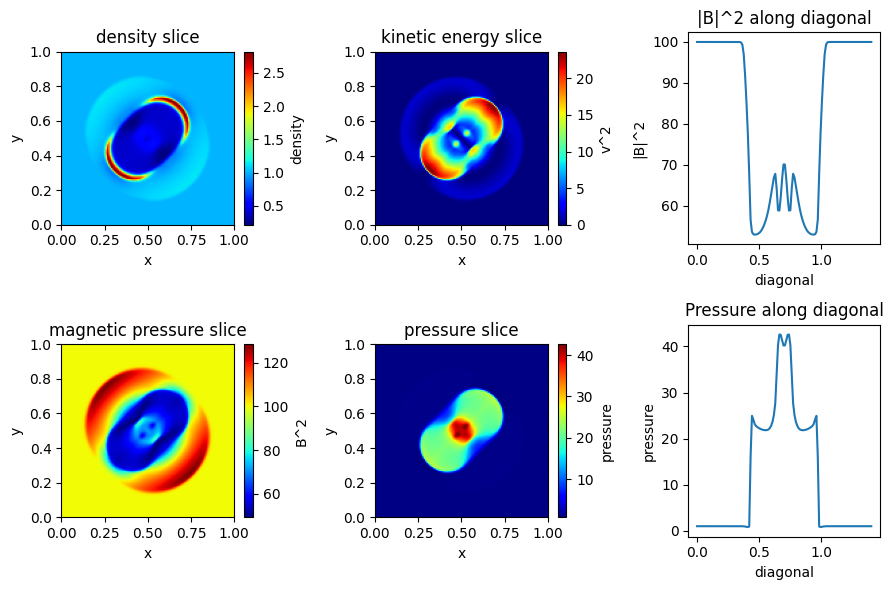

In [4]:
# plot
density = final_state[registered_variables.density_index]
pressure = final_state[registered_variables.pressure_index]
Bx = final_state[registered_variables.magnetic_index.x]
By = final_state[registered_variables.magnetic_index.y]
Bz = final_state[registered_variables.magnetic_index.z]
vx = final_state[registered_variables.velocity_index.x]
vy = final_state[registered_variables.velocity_index.y]
vz = final_state[registered_variables.velocity_index.z]
b_squared = Bx**2 + By**2 + Bz**2
v_squared = vx**2 + vy**2 + vz**2

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

# density
im = axs[0, 0].imshow(
    density[:, :, num_cells // 2],
    origin="lower",
    extent=(0, config.box_size, 0, config.box_size),
    cmap="jet",
)
cbar = make_axes_locatable(axs[0, 0]).append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, cax=cbar, label="density")
axs[0, 0].set_title("density slice")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

# log pressure
im = axs[1, 1].imshow(
    pressure[:, :, num_cells // 2],
    origin="lower",
    extent=(0, config.box_size, 0, config.box_size),
    cmap="jet",
)
cbar = make_axes_locatable(axs[1, 1]).append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, cax=cbar, label="pressure")
axs[1, 1].set_title("pressure slice")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")


im = axs[0, 1].imshow(
    v_squared[:, :, num_cells // 2],
    origin="lower",
    extent=(0, config.box_size, 0, config.box_size),
    cmap="jet",
)
cbar = make_axes_locatable(axs[0, 1]).append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, cax=cbar, label="v^2")
axs[0, 1].set_title("kinetic energy slice")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

im = axs[1, 0].imshow(
    b_squared[:, :, num_cells // 2],
    origin="lower",
    extent=(0, config.box_size, 0, config.box_size),
    cmap="jet",
)
cbar = make_axes_locatable(axs[1, 0]).append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, cax=cbar, label="B^2")
axs[1, 0].set_title("magnetic pressure slice")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")

# 0, 2: |B|^2 / 2 along the diagonal from the center
diag_indices = jnp.arange(0, num_cells)
B_diag = b_squared[diag_indices, diag_indices, num_cells // 2]
r_diag = jnp.sqrt((diag_indices) ** 2 + (diag_indices) ** 2) * (
    config.box_size / num_cells
)
axs[0, 2].plot(r_diag, B_diag)
axs[0, 2].set_ylabel("|B|^2")
axs[0, 2].set_xlabel("diagonal")
axs[0, 2].set_title("|B|^2 along diagonal")

# density along the vertical centerline
pressure_diag = pressure[diag_indices, diag_indices, num_cells // 2]
axs[1, 2].plot(r_diag, pressure_diag)
axs[1, 2].set_ylabel("pressure")
axs[1, 2].set_xlabel("diagonal")
axs[1, 2].set_title("Pressure along diagonal")

plt.tight_layout()